In [ ]:
import os
import pandas
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, auc, roc_auc_score
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Wczytanie danych

In [ ]:
df_benign  = pd.read_csv(os.path.join('/content/drive/MyDrive/Data/CSV_benign.csv'), low_memory=False)
df_malware = pd.read_csv(os.path.join('/content/drive/MyDrive/Data/CSV_malware.csv'), low_memory=False)

In [ ]:
df_benign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494135 entries, 0 to 494134
Data columns (total 38 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Country             385194 non-null  object 
 1   ASN                 385249 non-null  float64
 2   TTL                 494135 non-null  int64  
 3   IP                  386440 non-null  object 
 4   Domain              494135 non-null  object 
 5   State               217505 non-null  object 
 6   Registrant_Name     13637 non-null   object 
 7   Country.1           254093 non-null  object 
 8   Creation_Date_Time  362222 non-null  object 
 9   hex_32              494012 non-null  object 
 10  hex_8               494135 non-null  object 
 11  Domain_Name         397438 non-null  object 
 12  Alexa_Rank          440288 non-null  object 
 13  subdomain           494119 non-null  object 
 14  Organization        201746 non-null  object 
 15  len                 493777 non-nul

In [ ]:
df_malware.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country             4053 non-null   object 
 1   ASN                 4055 non-null   float64
 2   TTL                 4999 non-null   object 
 3   IP                  4098 non-null   object 
 4   Domain              4999 non-null   object 
 5   oc_8                4999 non-null   int64  
 6   longest_word        4999 non-null   object 
 7   Domain_Name         3968 non-null   object 
 8   dec_32              4999 non-null   int64  
 9   subdomain           4999 non-null   int64  
 10  sld                 4999 non-null   object 
 11  Registrant_Name     73 non-null     object 
 12  hex_32              4999 non-null   int64  
 13  Domain_Age          4428 non-null   object 
 14  entropy             4999 non-null   float64
 15  Name_Server_Count   4428 non-null   float64
 16  Emails

Usunięcie:
zduplikowanych danych,
kolumny 'Registrant_Name', która w większości była wypełniona wartościami NaN
oraz usunięcie wierszy z brakującymi wartościami NaN

In [ ]:
df_malware = df_malware.drop_duplicates()
df_benign = df_benign.drop_duplicates()

df_malware = df_malware.drop(columns=['Registrant_Name'])
df_benign = df_benign.drop(columns=['Registrant_Name'])

df_malware.dropna(inplace=True)
df_benign.dropna(inplace=True)

In [ ]:
df_malware.shape

(1546, 37)

In [ ]:
df_benign.shape

(131107, 37)

Dodanie odpowiednich labeli dla kategorii - benign label 0, malware label 1

In [ ]:
df_malware["Label"] = 1
df_benign ["Label"] = 0

ze względu na niezbilansowany rozkład klas, zastosowano funkcję *resample()*, aby zrównowaźyć rozkład kategorii. Połączono te kategorie i przypisano do ramki *data*

In [ ]:
df_benign_resampled = resample(df_benign, replace=False, n_samples=2000, random_state=42)
df_malware_resampled = resample(df_malware, replace=True, n_samples=2000, random_state=42)
data = pd.concat([df_malware_resampled , df_benign_resampled])

Podział danych na dane treningowe i dane testowe

In [ ]:
X = data.drop('Label', axis=1)
y = data['Label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Rozdzielenie i przetwarzanie kategorii numerycznych i kategorycznych. Przygotowanie danych

In [ ]:
cols_numerical = X_train.select_dtypes(include=['int64', 'float64']).columns
cols_categorical = X_train.select_dtypes(include=['object']).columns

X_train[cols_categorical] = X_train[cols_categorical].astype(str)
X_test[cols_categorical] = X_test[cols_categorical].astype(str)

transformer_numerical = Pipeline(steps = [
    ('num_trans', StandardScaler())
])

transformer_categorical = Pipeline(steps = [
    ('cat_trans', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers = [
    ('numerical', transformer_numerical, cols_numerical),
    ('categorical', transformer_categorical, cols_categorical)],
    remainder='passthrough'
)

 Pipeline oraz trening modelu ***regresji logistycznej*** na danych treningowych,  ocena modelu za pomocą miary dokładność (accuracy) na danych testowych, macierzy pomyłek (confusion matrix), ROC-AUC, precyzja (precision), czułość (recall), f1 score

Accuracy: 0.9175
ROC-AUC score 0.9149050878908699
Precision: 0.8903508771929824
Recall: 0.9620853080568721
F1_score: 0.9248291571753987


<Axes: >

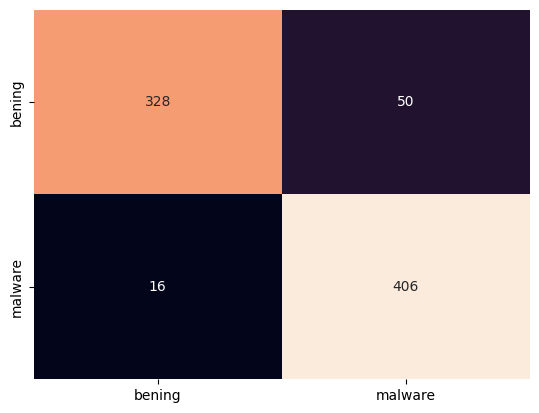

In [ ]:
pipe_lr = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier',  LogisticRegression(max_iter=500 ,random_state=42))
    ])

pipe_lr.fit(X_train, y_train)
accuracy_lr = pipe_lr.score(X_test, y_test)

y_pred_lr = (pipe_lr.predict(X_test))
print('Accuracy:', accuracy_lr)
print('ROC-AUC score', roc_auc_score(y_test, y_pred_lr))
print('Precision:', precision_score(y_test, y_pred_lr))
print('Recall:', recall_score(y_test, y_pred_lr))
print('F1_score:', f1_score(y_test, y_pred_lr))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt = 'd', xticklabels=['benign', 'malware'], yticklabels=['benign', 'malware'], cbar=False)

 Pipeline oraz trening modelu ***drzewa decyzyjnego*** na danych treningowych,  ocena modelu za pomocą miary dokładność (accuracy) na danych testowych, macierzy pomyłek (confusion matrix), ROC-AUC, precyzja (precision), czułość (recall), f1 score

Accuracy: 0.91125
ROC-AUC score 0.9099463376714562
Precision: 0.9016018306636155
Recall: 0.933649289099526
F1_score: 0.9173457508731082


<Axes: >

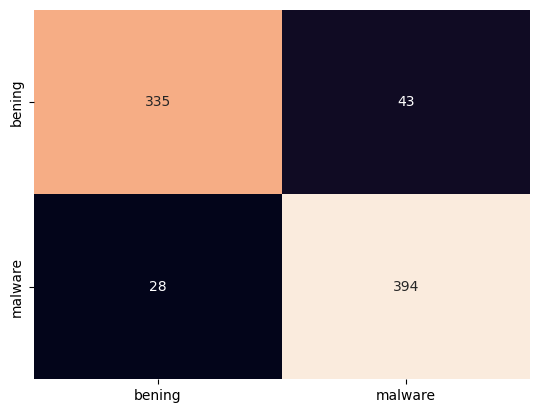

In [ ]:
pipe_dt = Pipeline(steps = [
                ('preprocessor', preprocessor),
               ('classifier',  DecisionTreeClassifier())
            ])
pipe_dt.fit(X_train, y_train)
accuracy_dt = pipe_dt.score(X_test, y_test)

y_pred_dt = (pipe_dt.predict(X_test))
print('Accuracy:', accuracy_dt)
print('ROC-AUC score', roc_auc_score(y_test, y_pred_dt))
print('Precision:', precision_score(y_test, y_pred_dt))
print('Recall:', recall_score(y_test, y_pred_dt))
print('F1_score:', f1_score(y_test, y_pred_dt))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt = 'd', xticklabels=['benign', 'malware'], yticklabels=['benign', 'malware'], cbar=False)

Pipeline oraz trening modelu oparty na ***lasach losowych*** na danych treningowych,  ocena modelu za pomocą miary dokładność (accuracy) na danych testowych, macierzy pomyłek (confusion matrix), ROC-AUC, precyzja (precision), czułość (recall), f1 score

Accuracy 0.9125
ROC-AUC score 0.911131171794679
Precision: 0.9018264840182648
Recall: 0.9360189573459715
F1_score: 0.9186046511627907


<Axes: >

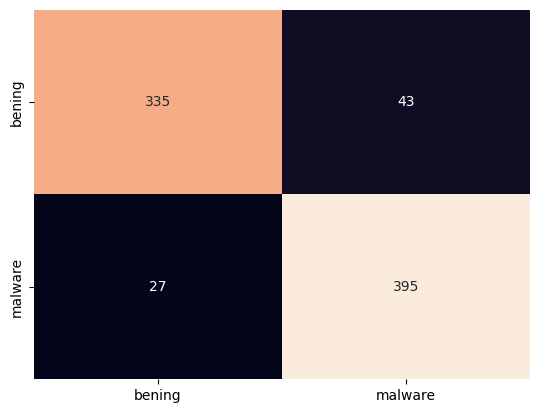

In [ ]:
pipe_rf = Pipeline(steps = [
                ('preprocessor', preprocessor),
               ('classifier', RandomForestClassifier( n_jobs=-1))
            ])
pipe_rf.fit(X_train, y_train)
accuracy_rf = pipe_rf.score(X_test, y_test)

y_pred_rf = (pipe_rf.predict(X_test))
print('Accuracy',accuracy_rf)
print('ROC-AUC score', roc_auc_score(y_test, y_pred_rf))
print('Precision:', precision_score(y_test, y_pred_rf))
print('Recall:', recall_score(y_test, y_pred_rf))
print('F1_score:', f1_score(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt = 'd', xticklabels=['benign', 'malware'], yticklabels=['benign', 'malware'], cbar=False)

 Pipeline oraz trening modelu ***k-najbliższego sąsiada*** na danych treningowych,  ocena modelu za pomocą miary dokładność (accuracy) na danych testowych, macierzy pomyłek (confusion matrix), ROC-AUC, precyzja (precision), czułość (recall), f1 score

Accuracy: 0.84125
ROC-AUC score 0.8397339451841822
Precision: 0.8375286041189931
Recall: 0.8672985781990521
F1_score: 0.8521536670547147


<Axes: >

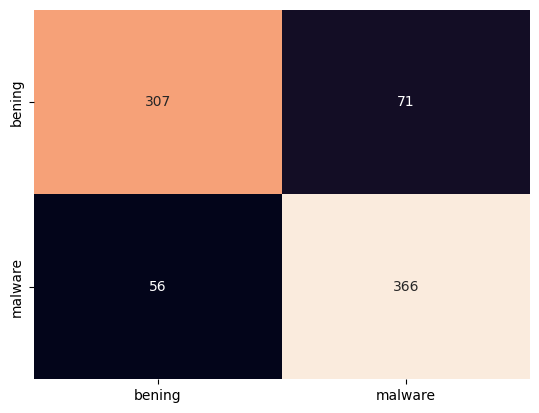

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
pipe_knn = Pipeline(steps = [
                ('preprocessor', preprocessor),
               ('classifier', KNeighborsClassifier(2))
            ])
pipe_knn.fit(X_train, y_train)
accuracy_knn = pipe_knn.score(X_test, y_test)

y_pred_knn = (pipe_knn.predict(X_test))
print('Accuracy:',accuracy_knn)
print('ROC-AUC score', roc_auc_score(y_test, y_pred_knn))
print('Precision:', precision_score(y_test, y_pred_knn))
print('Recall:', recall_score(y_test, y_pred_knn))
print('F1_score:', f1_score(y_test, y_pred_knn))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt = 'd', xticklabels=['benign', 'malware'], yticklabels=['benign', 'malware'], cbar=False)

W celu zwiększenia wydajności modelu, można zastosować walidację krzyżową

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
cv = KFold(n_splits=10, shuffle=True, random_state=42)
X[cols_categorical] = X[cols_categorical].astype(str)

scores = cross_val_score(pipe_knn, X, y, cv=cv, scoring='accuracy')
print('Cross-validation results:', scores)
print('Mean accuracy:', scores.mean())


Cross-validation results: [0.87   0.845  0.85   0.85   0.8475 0.875  0.865  0.8725 0.84   0.865 ]
Mean accuracy: 0.858


Porównanie modeli

In [ ]:
results= {
    'Model': ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'KNeighborsClassifier'],
    'Accuracy': [accuracy_lr, accuracy_dt, accuracy_rf, accuracy_knn],
    'ROC-AUC score': [roc_auc_score(y_test, y_pred_lr), roc_auc_score(y_test, y_pred_dt), roc_auc_score(y_test, y_pred_rf), roc_auc_score(y_test, y_pred_knn)],
    'Precision': [precision_score(y_test, y_pred_lr), precision_score(y_test, y_pred_dt), precision_score(y_test, y_pred_rf), precision_score(y_test, y_pred_knn)],
    'Recall': [recall_score(y_test, y_pred_lr), recall_score(y_test, y_pred_dt), recall_score(y_test, y_pred_rf), recall_score(y_test, y_pred_knn)],
    'F1_score': [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_dt), f1_score(y_test, y_pred_rf), f1_score(y_test, y_pred_knn)]
}

df = pd.DataFrame(results)
df

,Model,Accuracy,ROC-AUC score,Precision,Recall,F1_score
0,LogisticRegression,0.91750,0.914905,0.890351,0.962085,0.924829
1,DecisionTreeClassifier,0.91125,0.909946,0.901602,0.933649,0.917346
2,RandomForestClassifier,0.91250,0.911131,0.901826,0.936019,0.918605
3,KNeighborsClassifier,0.84125,0.839734,0.837529,0.867299,0.852154


Model regresji logicznej (LogisticRegression) osiągnął bardzo wysoką dokładność (accuracy) na poziomie 91.75%. ROC-AUC score wskazuje na dobrą zdolność modelu do rozróżniania klas, z wynikiem 0.91. Precision wyniosła 0.89 (model jest skłonny do wydawania pozytywnych predykcji w sposób ostrożny), a czułość (recall) wynosła 0.96, co oznacza, że model ma wysoką zdolność do wykrywania pozytywnych przypadków. F1-score, które uwzględnia precyzję i czułość, wynosi 0.92. Model drzewa decyzyjnego (DecisionTreeClassifier) i lasu losowego (RandomForestClassifier) uzyskały zbliżoną wydajność do modelu regresji logicznej. Najgorzej poradził sobie model k-najbliższych sąsiadów (KNeighborsClassifier), który uzyskał dokładność równą 84.12%.

---

Modele zostały wytrenowane na danych treningowych i przetestowane na danych testowych. Do oceny klasyfikatorów przedstawiono macierz pomyłek, miarę ROC-AUC, precyzję, czułość oraz f1 score. W celu poprawy wydajności zaproponowano zastosowanie walidacji krzyżowej. Dla nowych danych produkcyjnych, które nie były dostępne podczas treningu ani ewaluacji, można zachować zestaw testowy, w celu oceny modelu na nowych danych oraz monitorowanie jego wydajności i miar statystycznych